# Web Application Firewall using Machine Learning

## 0. Import Dependancies

In [1]:
import numpy as np
import pandas as pd
import csv
import pickle
import matplotlib.pyplot as plt
import seaborn
import string

from IPython.display import display
from scipy.stats import expon

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.decomposition import TruncatedSVD

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

from sklearn.cross_validation import ShuffleSplit
from sklearn.cross_validation import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 1. Data Gathering

## 2. Load Data

In [2]:
def text_to_dataframe(src_file,is_malicious,injection_type):
    
    #read files from the directory
    payloads_txt = open('data/{}.txt'.format(src_file),'r',encoding='UTF-8').readlines()
    
    #create pandas dataframe
    payloads = pd.DataFrame(payloads_txt,columns=['payload'])
    payloads['is_malicious'] = [is_malicious]*len(payloads)
    payloads['injection_type'] = [injection_type]*len(payloads)
    print ('Number of payloads: ' + str(len(payloads)))
    print('First 5 lines of ' + injection_type)
    display(payloads.head())
    
    return payloads

In [3]:
#concatenate all payload dataframes together
payloads = pd.DataFrame(columns=['payload','is_malicious','injection_type'])
payloads = payloads.append(text_to_dataframe('SQLiPayload',1,'SQLi'))
payloads = payloads.append(text_to_dataframe('XSSPayload',1,'XSS'))
payloads = payloads.append(text_to_dataframe('ShellPayload',1,'SHELL'))
payloads = payloads.append(text_to_dataframe('NormalData',0,'VALID'))
payloads = payloads.reset_index(drop=True)

Number of payloads: 2181
First 5 lines of SQLi


,payload,is_malicious,injection_type
0,﻿'\n,1,SQLi
1,a' or 1=1-- \n,1,SQLi
2,"""a"""" or 1=1--""\n",1,SQLi
3,or a = a\n,1,SQLi
4,a' or 'a' = 'a\n,1,SQLi


Number of payloads: 15395
First 5 lines of XSS


,payload,is_malicious,injection_type
0,"﻿data:text/html;alert(1)/*,<svg%20onload=eval(...",1,XSS
1,"'"">*/--></title></style></textarea></script%0A...",1,XSS
2,""" onclick=alert(1)//<button ‘ onclick=alert(1)...",1,XSS
3,"';alert(String.fromCharCode(88,83,83))//';aler...",1,XSS
4,""">><marquee><img src=x onerror=confirm(1)></ma...",1,XSS


Number of payloads: 330
First 5 lines of SHELL


,payload,is_malicious,injection_type
0,() { 0; }; touch /tmp/blns.shellshock1.fail;\n,1,SHELL
1,() { _; } >_[$($())] { touch /tmp/blns.shellsh...,1,SHELL
2,<<< %s(un='%s') = %u\n,1,SHELL
3,'+++ATH0\n,1,SHELL
4,/dev/null; touch /tmp/blns.fail ; echo\n,1,SHELL


Number of payloads: 118530
First 5 lines of VALID


,payload,is_malicious,injection_type
0,569993989\n,0,VALID
1,46201\n,0,VALID
2,Indianapolis\n,0,VALID
3,20354328\n,0,VALID
4,A8Cyj4uzrSgkGg4szKuHeI\n,0,VALID


## 3. Data Cleaning

### 1. Remove new lines and white spaces

In [4]:
payloads['payload'] = payloads['payload'].str.strip('\n')
payloads['payload'] = payloads['payload'].str.strip()

### 2. Remove empty data points

In [5]:
orig_data = len(payloads['payload'])
payloads = payloads[payloads['payload'].str.len() != 0]
print('Empty data points removed: ' + str(orig_data - len(payloads)))

Empty data points removed: 1


### 3. Remove malicious data points of length 1

In [6]:
orig_data = len(payloads['payload'])
payloads = payloads[(payloads['is_malicious'] == 0) | ((payloads['is_malicious'] == 1) & (payloads['payload'].str.len() > 1))]
print('Malicious data points of size 1 removed: ' + str(orig_data-len(payloads)))

Malicious data points of size 1 removed: 3


### 4. Remove duplicates

In [7]:
orig_data = len(payloads['payload'])
payloads = payloads.drop_duplicates(subset='payload', keep='last')
print('Duplicate data points removed: ' + str(orig_data-len(payloads)))

Duplicate data points removed: 26072


### 5. Reformat rows that to uniform format

In [8]:
payloads['payload'] = [payload[2:-1] if payload.startswith("b'") or payload.startswith('b"') 
                        else payload for payload in payloads['payload']]

### 6. Shuffle dataset

In [9]:
payloads = payloads.sample(frac=1).reset_index(drop=True)
payloads.index.name = 'index'

### 7. Remove null/NA/NaN as this can not be saved into .csv

In [10]:
payloads.to_csv('data/payloads.csv',encoding='UTF-8')
#reload dataframe from saved .csv. The dataframe will contain a few null values
payloads = pd.read_csv("data/payloads.csv",index_col='index',encoding='UTF-8') 
rows_before = len(payloads['payload'])
payloads = payloads[~payloads['payload'].isnull()]
print('null/NaN data points removed: ' + str(rows_before-len(payloads)))

null/NaN data points removed: 4


### 8. Save data to csv

In [11]:
payloads.to_csv('data/payloads.csv',encoding='UTF-8')

### 9. Load data from payload.csv to pandas dataframe

In [12]:
payloads = pd.read_csv("data/payloads.csv",index_col='index')
display(payloads.head(5))

,payload,is_malicious,injection_type
index,,,
0,"<div style=""list-style:url(http://foo.f)\20url...",1,XSS
1,74345001P,0,VALID
2,broccoli,0,VALID
3,<iframe src=`http://xssme.html5sec.org/?xss=<i...,1,XSS
4,federally,0,VALID


## 4. Feature Engineering

In [13]:
# Plot Function
def plot_feature_distribution(features):
    print('Properties of feature: ' + features.name)
    print(features.describe())
    f, ax = plt.subplots(1, figsize=(10, 8))
    ax.hist(features, bins=features.max()-features.min()+1, normed=1)
    ax.set_xlabel('value')
    ax.set_ylabel('fraction')
    
    plt.show()

### 1. Length of payload

,payload,is_malicious,injection_type,length
index,,,,
0,"<div style=""list-style:url(http://foo.f)\20url...",1,XSS,82
1,74345001P,0,VALID,9
2,broccoli,0,VALID,8
3,<iframe src=`http://xssme.html5sec.org/?xss=<i...,1,XSS,280
4,federally,0,VALID,9
5,Ninon,0,VALID,5
6,lamargue%40blogsmegumi.cs,0,VALID,25
7,San+Vicente+del+Raspeig%2FSant+Vicent+del+Raspeig,0,VALID,49
8,19277401C,0,VALID,9


Properties of feature: length
count    110356.000000
mean         16.559752
std          32.108760
min           1.000000
25%           6.000000
50%           9.000000
75%          14.000000
max         974.000000
Name: length, dtype: float64


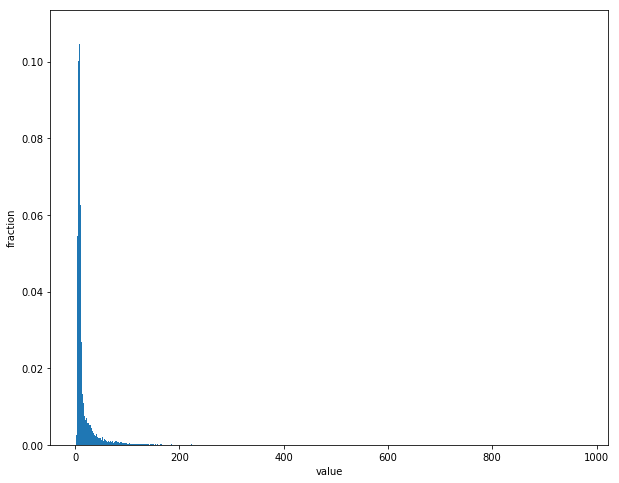

In [14]:
def feature_length(payloads):
    payloads['length'] = [len(str(row)) for row in payloads['payload']]
    return payloads

payloads = feature_length(payloads)
display(payloads.head(10))


plot_feature_distribution(payloads['length'])

### 2. Punctuation characters

,payload,is_malicious,injection_type,length,punctuation
index,,,,,
0,"<div style=""list-style:url(http://foo.f)\20url...",1,XSS,82,21
1,74345001P,0,VALID,9,0
2,broccoli,0,VALID,8,0
3,<iframe src=`http://xssme.html5sec.org/?xss=<i...,1,XSS,280,78
4,federally,0,VALID,9,0


Properties of feature: punctuation
count    110356.000000
mean          2.363750
std           9.771302
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         538.000000
Name: punctuation, dtype: float64


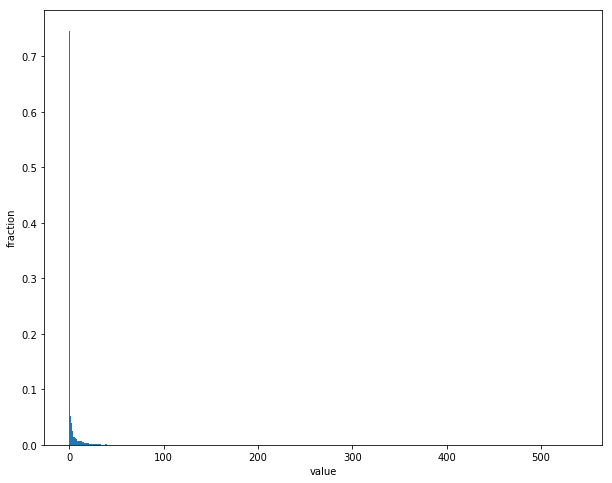

In [15]:
def feature_punctuation_characters(payloads):
    payloads['punctuation'] = [ len([1 for letter in str(row) if letter in string.punctuation]) for row in payloads['payload']]
    return payloads
    
feature_punctuation_characters(payloads)
display(payloads.head())
    
plot_feature_distribution(payloads['punctuation'])

### 3. SQL Keywords

pandas.core.frame.DataFrame

,payload,is_malicious,injection_type,length,punctuation,sql-keywords
index,,,,,,
0,"<div style=""list-style:url(http://foo.f)\20url...",1,XSS,82,21,1
1,74345001P,0,VALID,9,0,0
2,broccoli,0,VALID,8,0,0
3,<iframe src=`http://xssme.html5sec.org/?xss=<i...,1,XSS,280,78,6
4,federally,0,VALID,9,0,1


Properties of feature: sql-keywords
count    110356.000000
mean          0.196002
std           0.671689
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          15.000000
Name: sql-keywords, dtype: float64


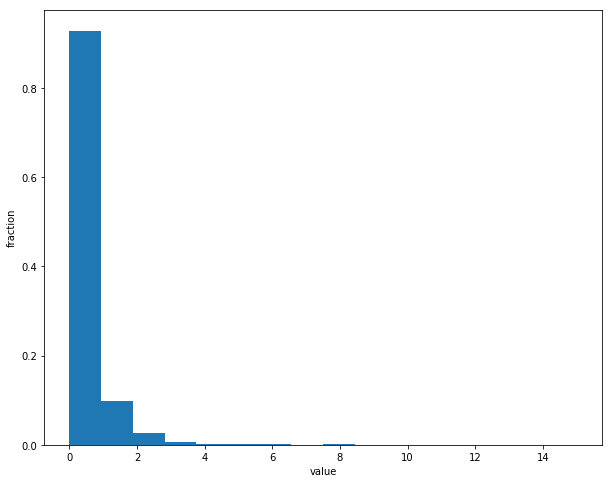

In [16]:
sql_keywords = pd.read_csv('data/SQLKeywords.txt', index_col=False)

def feature_sql_keywords(payloads):
    payloads['sql-keywords'] = [ len([1 for keyword in sql_keywords['Keyword'] if str(keyword).lower() in str(row).lower()]) for row in payloads['payload']]
    return payloads

feature_sql_keywords(payloads)
display(type(sql_keywords))
display(payloads.head())
plot_feature_distribution(payloads['sql-keywords'])

### 5. JavaScript keywords

,payload,is_malicious,injection_type,length,punctuation,sql-keywords,js-keywords
index,,,,,,,
0,"<div style=""list-style:url(http://foo.f)\20url...",1,XSS,82,21,1,1
1,74345001P,0,VALID,9,0,0,0
2,broccoli,0,VALID,8,0,0,0
3,<iframe src=`http://xssme.html5sec.org/?xss=<i...,1,XSS,280,78,6,9
4,federally,0,VALID,9,0,1,1


Properties of feature: js-keywords
count    110356.000000
mean          0.354852
std           0.821222
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          15.000000
Name: js-keywords, dtype: float64


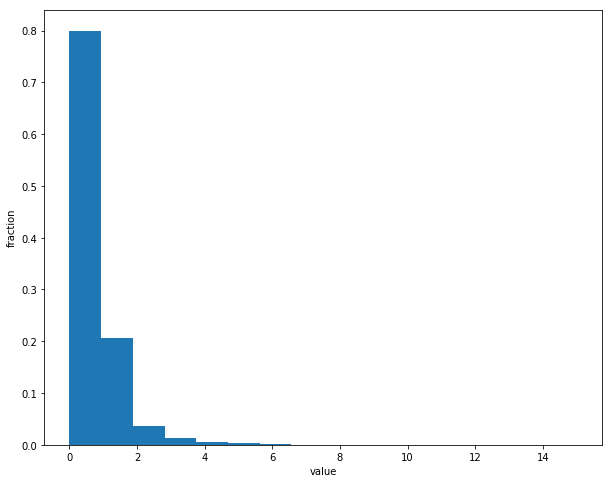

In [17]:
js_keywords = pd.read_csv('data/JSKeywords.txt', index_col=False)

def feature_js_keywords(payloads):
    payloads['js-keywords'] = [len([1 for keyword in js_keywords['Keyword'] if str(keyword).lower() in str(row).lower()]) for row in payloads['payload']]
    return payloads
    
feature_js_keywords(payloads)
display(payloads.head())    
plot_feature_distribution(payloads['js-keywords'])

### 6. Minimum byte value

,payload,is_malicious,injection_type,length,punctuation,sql-keywords,js-keywords,min-byte
index,,,,,,,,
0,"<div style=""list-style:url(http://foo.f)\20url...",1,XSS,82,21,1,1,32
1,74345001P,0,VALID,9,0,0,0,48
2,broccoli,0,VALID,8,0,0,0,98
3,<iframe src=`http://xssme.html5sec.org/?xss=<i...,1,XSS,280,78,6,9,32
4,federally,0,VALID,9,0,1,1,97


Properties of feature: min-byte
count    110356.000000
mean         71.225516
std          26.545790
min           9.000000
25%          48.000000
50%          75.000000
75%          97.000000
max         125.000000
Name: min-byte, dtype: float64


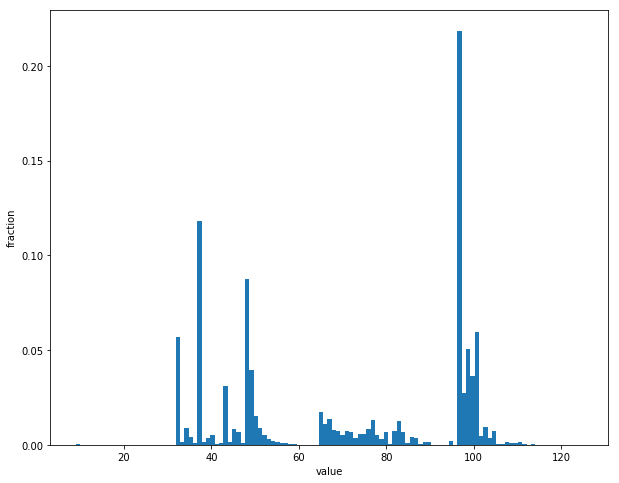

In [18]:
def feature_min_byte_value(payloads):
    payloads['min-byte'] = [ min(bytearray(str(row), 'utf8')) for row in payloads['payload']]
    return payloads

feature_min_byte_value(payloads)
display(payloads.head())

plot_feature_distribution(payloads['min-byte'])

### 7. Maximum byte value 

,payload,is_malicious,injection_type,length,punctuation,sql-keywords,js-keywords,min-byte,max-byte
index,,,,,,,,,
0,"<div style=""list-style:url(http://foo.f)\20url...",1,XSS,82,21,1,1,32,121
1,74345001P,0,VALID,9,0,0,0,48,80
2,broccoli,0,VALID,8,0,0,0,98,114
3,<iframe src=`http://xssme.html5sec.org/?xss=<i...,1,XSS,280,78,6,9,32,125
4,federally,0,VALID,9,0,1,1,97,121


Properties of feature: max-byte
count    110356.000000
mean        109.495161
std          20.327776
min          33.000000
25%         114.000000
50%         116.000000
75%         118.000000
max         240.000000
Name: max-byte, dtype: float64


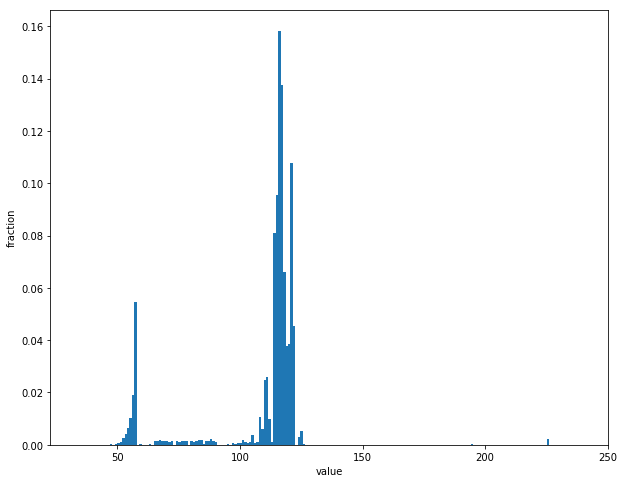

In [19]:
def feature_max_byte_value(payloads):
    payloads['max-byte'] = [ max(bytearray(str(row), 'utf8')) for row in payloads['payload']]
    return payloads

feature_max_byte_value(payloads)
display(payloads.head())

plot_feature_distribution(payloads['max-byte'])

### 8. Mean byte value

,payload,is_malicious,injection_type,length,punctuation,sql-keywords,js-keywords,min-byte,max-byte,mean-byte
index,,,,,,,,,,
0,"<div style=""list-style:url(http://foo.f)\20url...",1,XSS,82,21,1,1,32,121,91.024390
1,74345001P,0,VALID,9,0,0,0,48,80,54.222222
2,broccoli,0,VALID,8,0,0,0,98,114,105.625000
3,<iframe src=`http://xssme.html5sec.org/?xss=<i...,1,XSS,280,78,6,9,32,125,88.764286
4,federally,0,VALID,9,0,1,1,97,121,105.777778


Properties of feature: mean-byte
count    110356.000000
mean         92.513928
std          19.323097
min          33.000000
25%          83.000000
50%         101.000000
75%         107.000000
max         164.000000
Name: mean-byte, dtype: float64


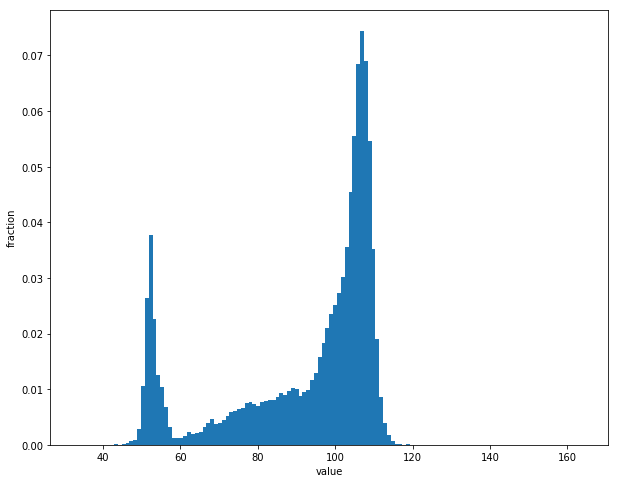

In [20]:
def feature_mean_byte_value(payloads):
    payloads['mean-byte'] = [ np.mean(bytearray(str(row), 'utf8')) for row in payloads['payload']]
    return payloads

feature_mean_byte_value(payloads)
display(payloads.head())

plot_feature_distribution(payloads['mean-byte'].astype(int))

### 9. Standard deviation byte value

,payload,is_malicious,injection_type,length,punctuation,sql-keywords,js-keywords,min-byte,max-byte,mean-byte,std-byte
index,,,,,,,,,,,
0,"<div style=""list-style:url(http://foo.f)\20url...",1,XSS,82,21,1,1,32,121,91.024390,28.952432
1,74345001P,0,VALID,9,0,0,0,48,80,54.222222,9.378199
2,broccoli,0,VALID,8,0,0,0,98,114,105.625000,5.914759
3,<iframe src=`http://xssme.html5sec.org/?xss=<i...,1,XSS,280,78,6,9,32,125,88.764286,29.192492
4,federally,0,VALID,9,0,1,1,97,121,105.777778,7.299586


Properties of feature: std-byte
count    110356.000000
mean         12.155732
std           9.201211
min           0.000000
25%           5.000000
50%           7.000000
75%          20.000000
max          75.000000
Name: std-byte, dtype: float64


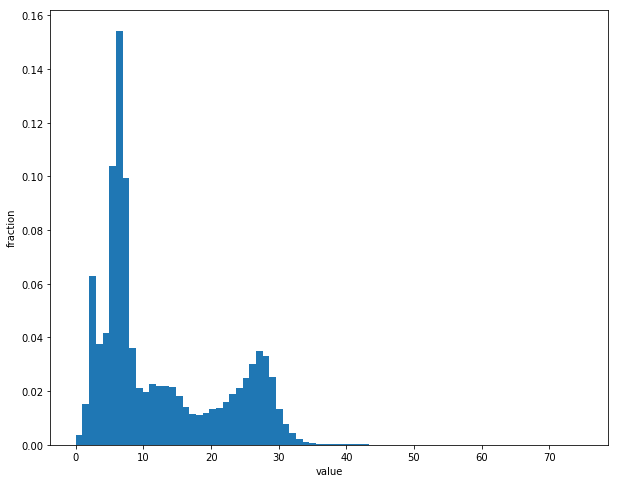

In [21]:
def feature_std_byte_value(payloads):    
    payloads['std-byte'] = [ np.std(bytearray(str(row), 'utf8')) for row in payloads['payload']]
    return payloads

feature_std_byte_value(payloads)
display(payloads.head())

plot_feature_distribution(payloads['std-byte'].astype(int))

### Feature 10: Distinct bytes

,payload,is_malicious,injection_type,length,punctuation,sql-keywords,js-keywords,min-byte,max-byte,mean-byte,std-byte,distinct-bytes
index,,,,,,,,,,,,
0,"<div style=""list-style:url(http://foo.f)\20url...",1,XSS,82,21,1,1,32,121,91.024390,28.952432,34
1,74345001P,0,VALID,9,0,0,0,48,80,54.222222,9.378199,7
2,broccoli,0,VALID,8,0,0,0,98,114,105.625000,5.914759,6
3,<iframe src=`http://xssme.html5sec.org/?xss=<i...,1,XSS,280,78,6,9,32,125,88.764286,29.192492,57
4,federally,0,VALID,9,0,1,1,97,121,105.777778,7.299586,7


Properties of feature: distinct-bytes
count    110356.000000
mean          9.483145
std           7.410805
min           1.000000
25%           5.000000
50%           7.000000
75%          10.000000
max          76.000000
Name: distinct-bytes, dtype: float64


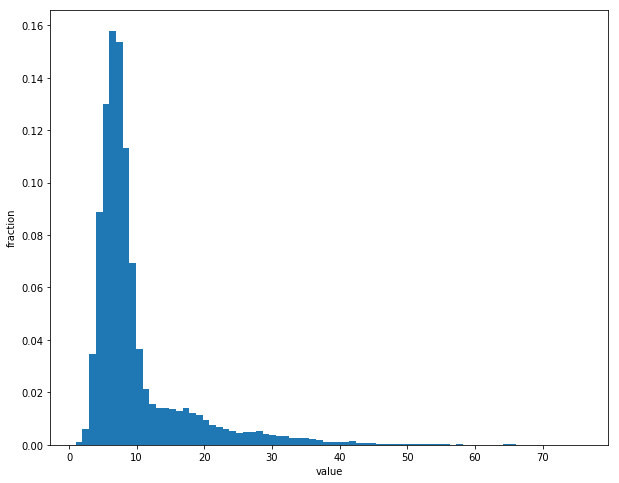

In [22]:
def feature_distinct_bytes(payloads):
    payloads['distinct-bytes'] = [ len(list(set(bytearray(str(row), 'utf8')))) for row in payloads['payload']]
    return payloads

feature_distinct_bytes(payloads)
display(payloads.head())

plot_feature_distribution(payloads['distinct-bytes'])

### 11. Number of non printable characthers within payload

,payload,is_malicious,injection_type,length,punctuation,sql-keywords,js-keywords,min-byte,max-byte,mean-byte,std-byte,distinct-bytes,non-printable
index,,,,,,,,,,,,,
0,"<div style=""list-style:url(http://foo.f)\20url...",1,XSS,82,21,1,1,32,121,91.024390,28.952432,34,0
1,74345001P,0,VALID,9,0,0,0,48,80,54.222222,9.378199,7,0
2,broccoli,0,VALID,8,0,0,0,98,114,105.625000,5.914759,6,0
3,<iframe src=`http://xssme.html5sec.org/?xss=<i...,1,XSS,280,78,6,9,32,125,88.764286,29.192492,57,0
4,federally,0,VALID,9,0,1,1,97,121,105.777778,7.299586,7,0


Properties of feature: non-printable
count    110356.000000
mean          0.007412
std           0.216737
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          30.000000
Name: non-printable, dtype: float64


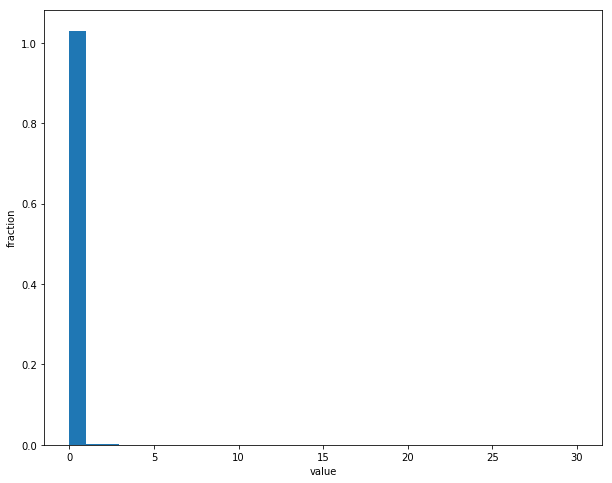

In [23]:
def feature_non_printable_characters(payloads):  
    payloads['non-printable'] = [ len([1 for letter in str(row) if letter not in string.printable]) for row in payloads['payload']]
    return payloads
    
feature_non_printable_characters(payloads)
display(payloads.head())
    
plot_feature_distribution(payloads['non-printable'])

## 5. Score Features

In [24]:
def create_features(payloads):
    features = feature_length(payloads)
    features = feature_punctuation_characters(features)
    features = feature_sql_keywords(features)
    features = feature_js_keywords(features)
    features = feature_max_byte_value(features)
    features = feature_min_byte_value(features)
    features = feature_mean_byte_value(features)
    features = feature_std_byte_value(features)
    features = feature_distinct_bytes(features)
    features = feature_non_printable_characters (features)
    del features['payload']

    return features

[ 1741929.44820417  1327625.82771143    33369.90307091    49252.5838244
    11962.11865915   209304.11862388    16749.65761306   202112.95919597
   289324.88425161     8314.92536977]
[ 1741929.45  1327625.83    33369.9     49252.58    11962.12   209304.12
    16749.66   202112.96   289324.88     8314.93]


['non-printable',
 'max-byte',
 'mean-byte',
 'sql-keywords',
 'js-keywords',
 'std-byte',
 'min-byte',
 'distinct-bytes',
 'punctuation',
 'length']

['length 8314.92536977',
 'js-keywords 11962.1186591',
 'min-byte 16749.6576131',
 'mean-byte 33369.9030709',
 'sql-keywords 49252.5838244',
 'distinct-bytes 202112.959196',
 'std-byte 209304.118624',
 'punctuation 289324.884252',
 'max-byte 1327625.82771',
 'non-printable 1741929.4482']

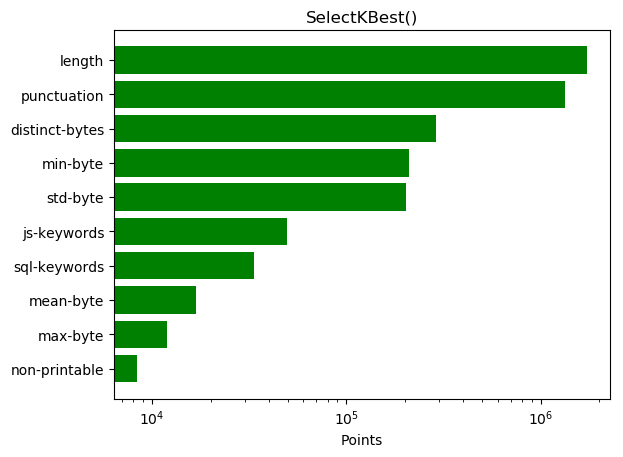

In [25]:
Y = payloads['is_malicious']
X = create_features(pd.DataFrame(payloads['payload'].copy()))


test = SelectKBest(score_func=chi2, k='all')
fit = test.fit(X, Y)
# summarize scores
print(fit.scores_)
features = fit.transform(X)
# summarize selected features
# summarize scores
np.set_printoptions(precision=2)
print(fit.scores_)

# Get the indices sorted by most important to least important
indices = np.argsort(fit.scores_)

# To get your top 10 feature names
featuress = []
for i in range(10):
    featuress.append(X.columns[indices[i]])

display(featuress)
display([featuress[i] + ' ' + str(fit.scores_[i]) for i in indices[range(10)]])


plt.rcdefaults()
fig, ax = plt.subplots()

y_pos = np.arange(len(featuress))
performance = 3 + 10 * np.random.rand(len(featuress))
error = np.random.rand(len(featuress))

ax.barh(y_pos, fit.scores_[indices[range(10)]],  align='center',
        color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(featuress)
ax.set_xscale('log')

#ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Points')
ax.set_title('SelectKBest()')

plt.show()

## 6. Model Selection and Hyperparameter tuning 

In [26]:
def train_model(clf, param_grid, X, Y):
    '''Trains and evaluates the model clf from input
    
    The function selects the best model of clf by optimizing for the validation data,
    then evaluates its performance using the out of sample test data.
    
    input - clf: the model to train
            param_grid: a dict of hyperparameters to use for optimization
            X: features
            Y: labels
    
    output - the best estimator (trained model)
             the confusion matrix from classifying the test data
    '''
    
    #First, partition into train and test data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    n_iter = 5
    #If number of possible iterations are less than prefered number of iterations, 
    #set it to the number of possible iterations
    #number of possible iterations are not less than prefered number of iterations if any argument is expon()
    #because expon() is continous (writing 100 instead, could be any large number)
    n_iter = min(n_iter,np.prod([
        100 if type(xs) == type(expon()) 
        else len(xs) 
        for xs in param_grid.values()
    ]))
    
    #perform a grid search for the best parameters on the training data.
    #Cross validation is made to select the parameters, so the training data is actually split into
    #a new train data set and a validation data set, K number of times
    cv = ShuffleSplit(n=len(X_train), n_iter=5, test_size=0.2, random_state=0) #DEBUG: n_iter=10
    #cv = KFold(n=len(X), n_folds=10)
    random_grid_search = RandomizedSearchCV(
        clf, 
        param_distributions=param_grid,
        cv=cv, 
        scoring='f1', 
        n_iter=n_iter, #DEBUG 1 
        random_state=5,
        refit=True,
        verbose=10
    )
    
    '''Randomized search used instead. We have limited computing power
    grid_search = GridSearchCV(
        clf,
        param_grid=param_grid,
        cv=cv,
        scoring='f1', #accuracy/f1/f1_weighted all give same result?
        verbose=10,
        n_jobs=-1
    )
    grid_search.fit(X_train, Y_train)
    '''
    random_grid_search.fit(X_train, Y_train)
    
    #Evaluate the best model on the test data
    Y_test_predicted = random_grid_search.best_estimator_.predict(X_test)
    Y_test_predicted_prob = random_grid_search.best_estimator_.predict_proba(X_test)[:, 1]

    confusion = confusion_matrix(Y_test, Y_test_predicted)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]

    #Calculate recall (sensitivity) from confusion matrix
    sensitivity = TP / float(TP + FN)
    
    #Calculate specificity from confusion matrix
    specificity = TN / float(TN + FP)

    #Calculate accuracy
    accuracy = (confusion[0][0] + confusion[1][1]) / (confusion.sum().sum())
    
    #Calculate axes of ROC curve
    fpr, tpr, thresholds = roc_curve(Y_test, Y_test_predicted_prob)
    
    #Area under the ROC curve
    auc = roc_auc_score(Y_test, Y_test_predicted_prob)

    return {
        'conf_matrix':confusion, 
        'accuracy':accuracy, 
        'sensitivity':sensitivity,
        'specificity':specificity,
        'auc':auc,
        'params':random_grid_search.best_params_,
        'model':random_grid_search.best_estimator_,
        'roc':{'fpr':fpr,'tpr':tpr,'thresholds':thresholds}
    }

## 7. Select ML algorithm

In [27]:
def create_classifier_inputs(subscript):
    
    classifier_inputs = {}
    
    # 1. Random Forest
    
    classifier_inputs[subscript + ' RandomForest'] = {
        'pipeline':RandomForestClassifier(
            max_depth=None,min_samples_split=2, random_state=0),
        'dict_params': {
            'n_estimators':[10,20,40,60]
        }
    }
    
    
    # 2. Support vector machine (SVM)
    '''
    classifier_inputs[subscript + ' SVM'] = {
        'pipeline':SVC(probability=True),
        'dict_params': {
            'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'gamma':[0.001, 0.0001,'auto'],
            'kernel':['rbf']
        }
    }
    '''
    
    return classifier_inputs

In [28]:
classifier_results = pd.DataFrame(columns=['accuracy','sensitivity','specificity','auc','conf_matrix','params','model','roc'])#,index=classifier_inputs.keys())
display(classifier_results.head())

,accuracy,sensitivity,specificity,auc,conf_matrix,params,model,roc


## 8. Train the model

In [29]:
classifier_inputs_custom = {}

#Get classifiers and parameters to optimize
classifier_inputs_custom.update(create_classifier_inputs('custom'))

#Extract payloads and labels
Y = payloads['is_malicious']
X = create_features(pd.DataFrame(payloads['payload'].copy()))

#Select the best features
X_new = SelectKBest(score_func=chi2, k=4).fit_transform(X,Y)

#Call train_model for every classifier and save results to classifier_results
for classifier_name, inputs in classifier_inputs_custom.items():
    if classifier_name in classifier_results.index.values.tolist():
        print('Skipping ' + classifier_name + ', already trained')
    else:
        result_dict = train_model(inputs['pipeline'],inputs['dict_params'],X,Y)
        classifier_results.loc[classifier_name] = result_dict

display(classifier_results)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] n_estimators=10 .................................................
[CV] ......... n_estimators=10, score=0.978956999085087, total=   0.6s
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] ........ n_estimators=10, score=0.9756997846816364, total=   0.6s
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV] ........ n_estimators=10, score=0.9743272502319827, total=   0.6s
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s


[CV] ........ n_estimators=10, score=0.9735725938009788, total=   0.6s
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.8s remaining:    0.0s


[CV] ......... n_estimators=10, score=0.971465213209362, total=   0.6s
[CV] n_estimators=20 .................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.5s remaining:    0.0s


[CV] ........ n_estimators=20, score=0.9792682926829268, total=   1.2s
[CV] n_estimators=20 .................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.8s remaining:    0.0s


[CV] ........ n_estimators=20, score=0.9794667483910512, total=   1.3s
[CV] n_estimators=20 .................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    6.1s remaining:    0.0s


[CV] ........ n_estimators=20, score=0.9765432098765433, total=   1.2s
[CV] n_estimators=20 .................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    7.4s remaining:    0.0s


[CV] ........ n_estimators=20, score=0.9761982393218129, total=   1.2s
[CV] n_estimators=20 .................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    8.7s remaining:    0.0s


[CV] ........ n_estimators=20, score=0.9737516005121639, total=   1.1s
[CV] n_estimators=40 .................................................
[CV] ........ n_estimators=40, score=0.9801889667784212, total=   2.3s
[CV] n_estimators=40 .................................................
[CV] ........ n_estimators=40, score=0.9794918885827978, total=   2.4s
[CV] n_estimators=40 .................................................
[CV] ........ n_estimators=40, score=0.9784747847478474, total=   2.2s
[CV] n_estimators=40 .................................................
[CV] ........ n_estimators=40, score=0.9761827079934747, total=   2.4s
[CV] n_estimators=40 .................................................
[CV] ..................... n_estimators=40, score=0.976, total=   2.3s
[CV] n_estimators=60 .................................................
[CV] ........ n_estimators=60, score=0.9799025578562728, total=   3.5s
[CV] n_estimators=60 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   42.2s finished


,accuracy,sensitivity,specificity,auc,conf_matrix,params,model,roc
custom RandomForest,0.997055,0.978825,0.998761,0.999584,"[[20158, 25], [40, 1849]]",{'n_estimators': 60},"(DecisionTreeClassifier(class_weight=None, cri...","{'fpr': [0.0, 0.0, 4.95466481693e-05, 4.954664..."


## 9.  Save classifier in a pickle file to be able to re-use them without re-training

In [30]:
pickle.dump( classifier_results, open( "data/trained_classifiers_custom_all_features.p", "wb" ) )
custom_features_classifiers = pickle.load( open("data/trained_classifiers_custom_all_features.p", "rb"))
display(custom_features_classifiers)

,accuracy,sensitivity,specificity,auc,conf_matrix,params,model,roc
custom RandomForest,0.997055,0.978825,0.998761,0.999584,"[[20158, 25], [40, 1849]]",{'n_estimators': 60},"(DecisionTreeClassifier(class_weight=None, cri...","{'fpr': [0.0, 0.0, 4.95466481693e-05, 4.954664..."


## 10. Bag of words techniques

#### a. 1-grams features 

In [31]:
def get1Grams(payload_obj):
    payload = str(payload_obj)
    ngrams = []
    for i in range(0,len(payload)-1):
        ngrams.append(payload[i:i+1])
    return ngrams
tfidf_vectorizer_1grams = TfidfVectorizer(tokenizer=get1Grams)
count_vectorizer_1grams = CountVectorizer(min_df=1, tokenizer=get1Grams)

#### b. 2-grams features

In [32]:
def get2Grams(payload_obj):
    payload = str(payload_obj)
    ngrams = []
    for i in range(0,len(payload)-2):
        ngrams.append(payload[i:i+2])
    return ngrams

tfidf_vectorizer_2grams = TfidfVectorizer(tokenizer=get2Grams)
count_vectorizer_2grams = CountVectorizer(min_df=1, tokenizer=get2Grams)

#### c. Apply random forest

In [33]:
def classifier_inputs_using_vectorizers(vectorizer, subscript):
    
    classifier_in = {}
    
    classifier_in[subscript + ' RandomForest'] = {
        'pipeline':Pipeline([('vect', vectorizer),('clf',RandomForestClassifier(
            max_depth=None,min_samples_split=2, random_state=0))]),
        'dict_params': {
            'vect__min_df':[1,2,5,10,20,40],
            'clf__n_estimators':[10,20,40,60]
        }
    }
         
    return classifier_in

In [ ]:
classifier_results_grams = pd.DataFrame(columns=['accuracy','sensitivity','specificity','auc','conf_matrix','params','model','roc'])#,index=classifier_inputs.keys())
display(classifier_results_grams.head())

,accuracy,sensitivity,specificity,auc,conf_matrix,params,model,roc


#### d. Train the model

In [ ]:
classifier_in = {}
classifier_in.update(classifier_inputs_using_vectorizers(count_vectorizer_1grams,'count 1grams'))
classifier_in.update(classifier_inputs_using_vectorizers(count_vectorizer_2grams,'count 2grams'))

classifier_in.update(classifier_inputs_using_vectorizers(tfidf_vectorizer_1grams,'tfidf 1grams'))
classifier_in.update(classifier_inputs_using_vectorizers(tfidf_vectorizer_2grams,'tfidf 2grams'))

X = payloads['payload'] 
Y = payloads['is_malicious']

for classifier_name, inputs in classifier_in.items():
    display(inputs['dict_params'])
    if classifier_name in classifier_results_grams.index.values.tolist():
        print('Skipping ' + classifier_name + ', already trained')
    else:
        result_dict = train_model(inputs['pipeline'],inputs['dict_params'],X,Y)
        classifier_results_grams.loc[classifier_name] = result_dict

display(classifier_results_grams)

{'clf__n_estimators': [10, 20, 40, 60], 'vect__min_df': [1, 2, 5, 10, 20, 40]}

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] vect__min_df=5, clf__n_estimators=60 ............................
[CV]  vect__min_df=5, clf__n_estimators=60, score=0.9915458937198067, total=   6.5s
[CV] vect__min_df=5, clf__n_estimators=60 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.2s remaining:    0.0s


[CV]  vect__min_df=5, clf__n_estimators=60, score=0.9941949282004278, total=   6.4s
[CV] vect__min_df=5, clf__n_estimators=60 ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.3s remaining:    0.0s


[CV]  vect__min_df=5, clf__n_estimators=60, score=0.9904878797177048, total=   6.4s
[CV] vect__min_df=5, clf__n_estimators=60 ............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.6s remaining:    0.0s


[CV]  vect__min_df=5, clf__n_estimators=60, score=0.9889682024659312, total=   7.1s
[CV] vect__min_df=5, clf__n_estimators=60 ............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   33.5s remaining:    0.0s


[CV]  vect__min_df=5, clf__n_estimators=60, score=0.9895271342430975, total=   7.3s
[CV] vect__min_df=5, clf__n_estimators=10 ............................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   42.8s remaining:    0.0s


[CV]  vect__min_df=5, clf__n_estimators=10, score=0.9899969687784176, total=   1.9s
[CV] vect__min_df=5, clf__n_estimators=10 ............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   45.5s remaining:    0.0s


[CV]  vect__min_df=5, clf__n_estimators=10, score=0.9902080783353734, total=   1.9s
[CV] vect__min_df=5, clf__n_estimators=10 ............................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   48.3s remaining:    0.0s


[CV]  vect__min_df=5, clf__n_estimators=10, score=0.9889298892988929, total=   1.7s
[CV] vect__min_df=5, clf__n_estimators=10 ............................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   50.9s remaining:    0.0s


[CV]  vect__min_df=5, clf__n_estimators=10, score=0.9876221498371336, total=   1.8s
[CV] vect__min_df=5, clf__n_estimators=10 ............................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   53.5s remaining:    0.0s


[CV]  vect__min_df=5, clf__n_estimators=10, score=0.9885496183206106, total=   1.8s
[CV] vect__min_df=40, clf__n_estimators=40 ...........................
[CV]  vect__min_df=40, clf__n_estimators=40, score=0.9924448473859172, total=   4.6s
[CV] vect__min_df=40, clf__n_estimators=40 ...........................
[CV]  vect__min_df=40, clf__n_estimators=40, score=0.9929728078215704, total=   4.5s
[CV] vect__min_df=40, clf__n_estimators=40 ...........................
[CV]  vect__min_df=40, clf__n_estimators=40, score=0.9917203311867525, total=   4.3s
[CV] vect__min_df=40, clf__n_estimators=40 ...........................
[CV]  vect__min_df=40, clf__n_estimators=40, score=0.9883040935672514, total=   4.5s
[CV] vect__min_df=40, clf__n_estimators=40 ...........................
[CV]  vect__min_df=40, clf__n_estimators=40, score=0.9904701397712834, total=   4.5s
[CV] vect__min_df=1, clf__n_estimators=60 ............................


In [ ]:
pickle.dump( classifier_results_grams, open( "data/trained_classifiers.p", "wb" ) )

## 11. Integrate WAF with Webserver

In [ ]:
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

def get2Grams(payload_obj):
   
    payload = str(payload_obj)
    ngrams = []
    for i in range(0,len(payload)-2):
        ngrams.append(payload[i:i+2])
    return ngrams

classifier = pickle.load( open("data/tfidf_2grams_randomforest.p", "rb"))

def injection_test(inputs):
    variables = inputs.split('&')
    values = [ variable.split('=')[1] for variable in variables]
    print(values)
    return 'MALICIOUS' if classifier.predict(values).sum() > 0 else 'NOT_MALICIOUS'

In [ ]:
#test injection_test
display(injection_test("val1=<script>alert(0)</script>"))
display(injection_test("val1=Hello World"))

## 12. Learning Curves

In [ ]:
def plot_learning_curve(df_row,X,Y):
    '''Plots the learning curve of a classifier with its parameters
    
    input - df_row: row of classifier_result
            X: payload data
            Y: labels
    '''
    #The classifier to plot learning curve for
    estimator = df_row['model']
    
    title = 'Learning curves for classifier ' + df_row.name
    train_sizes = np.linspace(0.1,1.0,5)
    cv = ShuffleSplit(n=len(X), n_iter=3, test_size=0.2, random_state=0)
    
    #plot settings
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    print('learning curve in process...')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, Y, cv=cv, n_jobs=-1, train_sizes=train_sizes, verbose=0) #Change verbose=10 to print progress
    print('Learning curve done!')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

In [ ]:
#plot learning curve for tfidf 1grams RandomForest
X = payloads['payload']
Y = payloads['is_malicious']
plot_learning_curve(classifier_results_gramss.iloc[0],X,Y)


#plot learning curve for custom Random Forest
X = create_features(pd.DataFrame(payloads['payload'].copy()))
Y = payloads['is_malicious']
plot_learning_curve(classifier_results.iloc[0],X,Y)